In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
import pandas as pd
import os,itertools
from scipy.interpolate import griddata
import pyslha
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
def interpolateData(x,y,z,nx=200,ny=200,method='linear',fill_value=np.nan,xnew=None,ynew=None):

    if x.min() == x.max() or y.min() == y.max(): # Can not interpolate
        return None,None,None
    elif xnew is None or ynew is None:
        xnew = np.linspace(x.min(),x.max(),nx)
        ynew = np.linspace(y.min(),y.max(),ny)

    xi = np.array([list(v) for v in itertools.product(xnew,ynew)])
    znew = griddata(list(zip(x,y)),z,xi=xi, 
                    method=method,fill_value=fill_value)
    znew = np.reshape(znew,(len(xnew),len(ynew)))
    xnew,ynew  = np.meshgrid(xnew,ynew,indexing='ij')

    return xnew,ynew,znew

In [3]:
# T1Disp

readSummary = True # whether to read SModelS results or load stored data

# Read SModelS summary
if readSummary:
    df = pd.read_csv('T1Disp_summary.txt',skiprows=3,sep='\\s+')
    condition = df['r_max'].notna()
    df = df[condition]

    # Define the filter function
    def filter_condition(row):
        f = row['#filename']
        if f != 'coordinates' and f != 'recipe':
            parts = f.split('_')
            m1 = parts[1]
            m2 = parts[3]
            if m2 == '100' and float(m1) - float(m2) != 30:
                return True
        return False

    # Apply the filter to the DataFrame
    df = df[df.apply(filter_condition, axis=1)]
    
    # Add model data
    slha_dir = '/Users/altakach/SModelS3/smodels/run-dir-validation-ATLAS-SUSY-18-42-T1Disp/slha/'
    modelData = []
    for f in df['#filename']:
        data = pyslha.readSLHAFile(os.path.join(slha_dir,f))
        mN1 = abs(data.blocks['MASS'][1000022])
        mGo = abs(data.blocks['MASS'][1000021])
        width_Go = data.decays[1000021].totalwidth
        modelData.append([mGo,mN1,width_Go])
    modelData = np.array(modelData)
    df[['mGo','mN1','wGo']] = modelData
    # Save to CSV
    df.to_csv('validation_data_T1Disp.csv')
else:
    # Read stored results
    df = pd.read_csv('validation_data_T1Disp.csv')


In [4]:
x,y = df['mGo'], 6.582e-25 / (df['wGo']*10**-9)
rValues = df['r_max']
nx = len(x)
ny = len(y)

ny = 10000
print(nx)
print(ny)

xnew,ynew,znew = interpolateData(x,y,rValues,nx=nx,ny=ny,fill_value=0.0)

5561
10000


In [5]:
# Official curve
excATLAS = np.genfromtxt('../orig/Rhadrons_Obs_massLim.csv',skip_header=1,delimiter=',')

# Skip the last element (last row) from the array becasue it's 0 GeV that is inf seconds
excATLAS = excATLAS[:-1]
print(excATLAS)
# Convert the first column from GeV to nano seconds
excATLAS[:, 0] = 6.582e-25 / (excATLAS[:, 0] * 10**-9)
print(excATLAS)


[[6.58200000e-16 1.63800000e+03]
 [4.38800000e-16 1.81100000e+03]
 [3.13428571e-16 1.95000000e+03]
 [2.19400000e-16 2.06900000e+03]
 [1.31640000e-16 2.18300000e+03]
 [9.40285714e-17 2.22800000e+03]
 [6.58200000e-17 2.26200000e+03]
 [4.38800000e-17 2.27000000e+03]
 [3.13428571e-17 2.27400000e+03]
 [2.19400000e-17 2.26600000e+03]
 [1.68769231e-17 2.25800000e+03]
 [1.29058824e-17 2.24300000e+03]
 [9.97272727e-18 2.22700000e+03]
 [7.56551724e-18 2.21000000e+03]
 [5.92972973e-18 2.19400000e+03]
 [6.58200000e-20 2.05600000e+03]]
[[1.000e+00 1.638e+03]
 [1.500e+00 1.811e+03]
 [2.100e+00 1.950e+03]
 [3.000e+00 2.069e+03]
 [5.000e+00 2.183e+03]
 [7.000e+00 2.228e+03]
 [1.000e+01 2.262e+03]
 [1.500e+01 2.270e+03]
 [2.100e+01 2.274e+03]
 [3.000e+01 2.266e+03]
 [3.900e+01 2.258e+03]
 [5.100e+01 2.243e+03]
 [6.600e+01 2.227e+03]
 [8.700e+01 2.210e+03]
 [1.110e+02 2.194e+03]
 [1.000e+04 2.056e+03]]


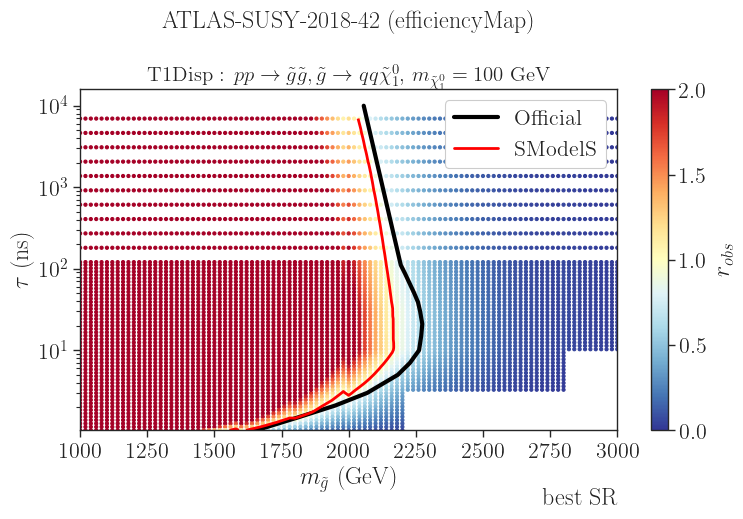

In [6]:
fig = plt.figure(figsize=(8,6))

# Plot ATLAS curve
plt.plot(excATLAS[:,1], excATLAS[:,0], label='Official', linewidth=3, linestyle='-', color='black')

# Plot contour
contour = plt.contour(xnew, ynew, znew, [1.0], colors='red', linestyles=['-'], linewidths=2.0)

# Plot scatter
plt.scatter(x, y, c=rValues, s=5, cmap=plt.colormaps.get_cmap('RdYlBu_r'), vmin=0., vmax=2.)

# Add labels and title
plt.ylabel(r'$\tau$ (ns)')
plt.xlabel(r'$m_{\tilde{g}}$ (GeV)')
plt.yscale('log')
plt.title(r'T1Disp : $p p \to \tilde{g} \tilde{g}, \tilde{g} \to q q \tilde{\chi}^0_1$, $m_{\tilde{\chi}_1^0} = 100 \textrm{ GeV}$ ', fontsize=15)

# Add colorbar
plt.colorbar(label=r'$r_{obs}$')

# Create a custom legend entry for the contour
contour_legend = Line2D([0], [0], color='red', linestyle='-', linewidth=2.0, label='SModelS')

# Append the new legend entry to the existing ones
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(contour_legend)
labels.append('SModelS')

# Update legend with all entries
plt.legend(handles=handles, labels=labels, framealpha=1.0, loc='upper right')#,bbox_to_anchor=(2, 1))

# Add text above the plot in the middle
plt.text(0.5, 1.2, 'ATLAS-SUSY-2018-42 (efficiencyMap)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Add text at the bottom right
plt.text(1, -0.2, 'best SR', horizontalalignment='right', verticalalignment='center', transform=plt.gca().transAxes)


# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('T1Disp.png')
plt.show()

In [7]:
# T1Disp compressed

readSummary = True # whether to read SModelS results or load stored data

# Read SModelS summary
if readSummary:
    df_c = pd.read_csv('T1Disp_summary.txt',skiprows=3,sep='\\s+')
    condition = df_c['r_max'].notna()
    df_c = df_c[condition]

    # Define the filter function
    def filter_condition(row):
        f = row['#filename']
        if f != 'coordinates' and f != 'recipe':
            parts = f.split('_')
            m1 = parts[1]
            m2 = parts[3]
            if float(m1) - float(m2) == 30:
                return True
        return False

    # Apply the filter to the DataFrame
    df_c = df_c[df_c.apply(filter_condition, axis=1)]
    
    # Add model data
    slha_dir = '/Users/altakach/SModelS3/smodels/run-dir-validation-ATLAS-SUSY-18-42-T1Disp/slha/'
    modelData_c = []
    for f in df_c['#filename']:
        data = pyslha.readSLHAFile(os.path.join(slha_dir,f))
        mN1 = abs(data.blocks['MASS'][1000022])
        mGo = abs(data.blocks['MASS'][1000021])
        width_Go = data.decays[1000021].totalwidth
        modelData_c.append([mGo,mN1,width_Go])
    modelData_c = np.array(modelData_c)
    df_c[['mGo','mN1','wGo']] = modelData_c
    # Save to CSV
    df_c.to_csv('validation_data_T1Disp_comporessed.csv')
else:
    # Read stored results
    df_c = pd.read_csv('validation_data_T1Disp_comporessed.csv')


In [8]:
x_c,y_c = df_c['mGo'], 6.582e-25 / (df_c['wGo']*10**-9)
rValues_c = df_c['r_max']
nx_c = len(x_c)
ny_c = len(y_c)

nx_c = 25

xnew_c,ynew_c,znew_c = interpolateData(x_c,y_c,rValues_c,nx=nx_c,ny=ny_c,fill_value=0.0)

In [9]:
# Official curve
excATLAS_c = np.genfromtxt('../orig/Rhadrons_Obs_massLim_Compressed.csv',skip_header=1,delimiter=',')

# Skip the last element (last row) from the array becasue it's 0 GeV that is inf seconds
excATLAS_c = excATLAS_c[:-1]
print(excATLAS_c)
# Convert the first column from GeV to nano seconds
excATLAS_c[:, 0] = 6.582e-25 / (excATLAS_c[:, 0] * 10**-9)
print(excATLAS_c)


[[6.58200000e-16 1.44100000e+03]
 [3.13428571e-16 1.68700000e+03]
 [2.19400000e-16 1.81600000e+03]
 [1.31640000e-16 1.90300000e+03]
 [9.40285714e-17 2.00100000e+03]
 [6.58200000e-17 2.03000000e+03]
 [4.38800000e-17 2.04400000e+03]
 [3.13428571e-17 2.06100000e+03]
 [2.19400000e-17 2.06400000e+03]
 [6.58200000e-20 2.05600000e+03]]
[[1.000e+00 1.441e+03]
 [2.100e+00 1.687e+03]
 [3.000e+00 1.816e+03]
 [5.000e+00 1.903e+03]
 [7.000e+00 2.001e+03]
 [1.000e+01 2.030e+03]
 [1.500e+01 2.044e+03]
 [2.100e+01 2.061e+03]
 [3.000e+01 2.064e+03]
 [1.000e+04 2.056e+03]]


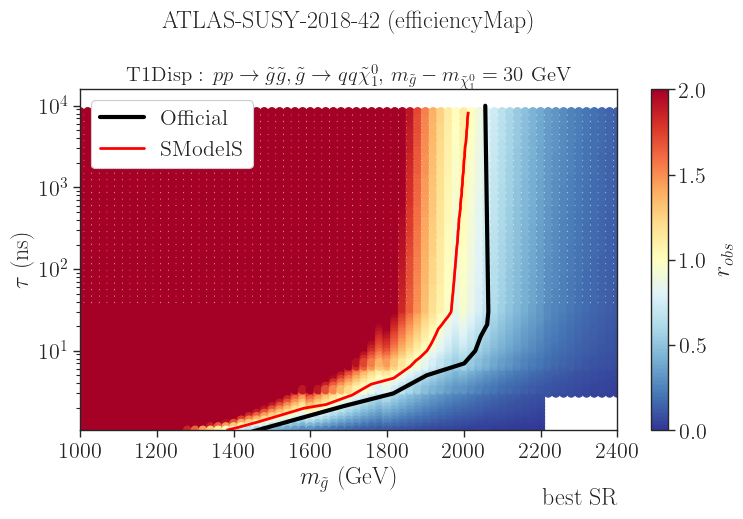

In [10]:
fig = plt.figure(figsize=(8,6))

# Plot ATLAS curve
plt.plot(excATLAS_c[:,1], excATLAS_c[:,0], label='Official', linewidth=3, linestyle='-', color='black')

# Plot contour
contour = plt.contour(xnew_c, ynew_c, znew_c, [1.0], colors='red', linestyles=['-'], linewidths=2.0)

# Plot scatter
plt.scatter(x_c, y_c, c=rValues_c, s=35, cmap=plt.colormaps.get_cmap('RdYlBu_r'), vmin=0., vmax=2.)

# Add labels and title
plt.ylabel(r'$\tau$ (ns)')
plt.xlabel(r'$m_{\tilde{g}}$ (GeV)')
plt.yscale('log')
plt.title(r'T1Disp : $p p \to \tilde{g} \tilde{g}, \tilde{g} \to q q \tilde{\chi}^0_1$, $m_{\tilde{g}} - m_{\tilde{\chi}_1^0} = 30 \textrm{ GeV}$ ', fontsize=15)

# Add colorbar
plt.colorbar(label=r'$r_{obs}$')

# Create a custom legend entry for the contour
contour_legend = Line2D([0], [0], color='red', linestyle='-', linewidth=2.0, label='SModelS')

# Append the new legend entry to the existing ones
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(contour_legend)
labels.append('SModelS')

# Update legend with all entries
plt.legend(handles=handles, labels=labels, framealpha=1.0, loc='upper left')#,bbox_to_anchor=(2, 1))

# Add text above the plot in the middle
plt.text(0.5, 1.2, 'ATLAS-SUSY-2018-42 (efficiencyMap)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Add text at the bottom right
plt.text(1, -0.2, 'best SR', horizontalalignment='right', verticalalignment='center', transform=plt.gca().transAxes)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('T1Disp_compressed.png')
plt.show()